In [1]:
import os

import SimpleITK

os.chdir('/opt/project')
print(os.getcwd())

/opt/project


In [ ]:
import warnings
import pandas as pd
import os
import shutil

# for copying meningioma data from the original folder structure to one suitable with autorad

from multiprocessing import Pool


def process_patient(patient_info):
    patient_src, dest_patient_folder = patient_info
    expected_files = {'ADC.nii.gz', 'flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'mask.nii.gz'}
    found_files = set()
    for file in os.listdir(patient_src):
        if file.endswith('.nii') or file.endswith('.gz'):
            if 'ADC' in file:
                new_filename = 'ADC.nii'
            elif 'flair' in file:
                new_filename = 'flair.nii.gz'
            elif 't1ce' in file:
                new_filename = 't1ce.nii.gz'
            elif 't1' in file:
                new_filename = 't1.nii.gz'
            elif 't2' in file:
                new_filename = 't2.nii.gz'
            elif '_1.nii' in file or '_2.nii' in file or '_3.nii' in file:
                new_filename = 'mask.nii.gz'
            else:
                warnings.warn(f"Unexpected file {file} in patient folder {patient_src}")
                continue

            src_file_path = os.path.join(patient_src, file)
            dest_file_path = os.path.join(dest_patient_folder, new_filename)
            shutil.copy(src_file_path, dest_file_path)
            print(f"Copied file {src_file_path} to {dest_file_path}")

            found_files.add(new_filename)

    if expected_files != found_files:
        missing_files = expected_files - found_files
        warnings.warn(f"Missing files {missing_files} in patient folder {patient_src}")

    return dest_patient_folder


def copy_patient_data(src_dir, dest_dir, n_cpu=2):
    """
    Copies patient data from the source directory to the destination directory
    while maintaining an ascending pattern of integer-based patient IDs. The function
    creates a mapping of patient IDs, grades, and their original data paths,
    and saves the mapping to a CSV file. It also renames the files as per the required format.

    Parameters:
        src_dir (str): The path to the source directory containing patient data organized by grades.
        dest_dir (str): The path to the destination directory where the copied patient data will be stored.

    Returns:
        None: The function performs the copy operation, file renaming, and saves the mapping to a CSV file.

    Raises:
        FileNotFoundError: If any of the expected files are missing.
        ValueError: If there are additional files that don't match the pattern.
    """
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    patient_data = []
    patient_info_list = []
    for grade_folder in os.listdir(src_dir):
        grade_path = os.path.join(src_dir, grade_folder)
        if os.path.isdir(grade_path):
            for patient_folder in os.listdir(grade_path):
                patient_src = os.path.join(grade_path, patient_folder)
                if os.path.isdir(patient_src):
                    dest_patient_id = len(os.listdir(dest_dir)) + 1
                    dest_patient_folder = os.path.join(dest_dir, f"ID_{dest_patient_id}")
                    os.makedirs(dest_patient_folder, exist_ok=True)
                    patient_info_list.append((patient_src, dest_patient_folder))
                    grade = 1 if grade_folder == 'Grade1Data' else 2
                    patient_data.append((f"ID_{dest_patient_id}", grade, patient_src))

    # Process patient data in parallel using multiprocessing
    with Pool(n_cpu) as pool:
        dest_patient_folders = pool.map(process_patient, patient_info_list)

    # Create a pandas DataFrame from the patient_data list
    df = pd.DataFrame(patient_data, columns=["Patient_ID", "Grade", "Original_Data_Path"])

    # Save the DataFrame to a CSV file
    df.to_csv("patient_grade_mapping.csv", index=False)


copy_patient_data('./data/meningioma', './data/meningioma_data')

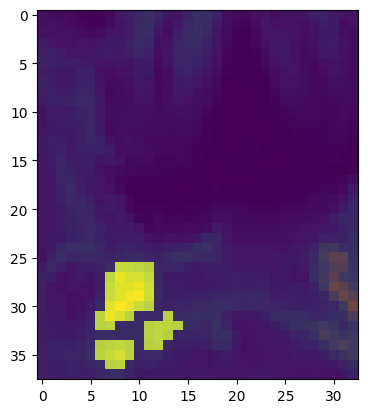

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(sitk.GetArrayFromImage(image)[12,:,:])
plt.imshow(sitk.GetArrayFromImage(mask)[12,:,:], alpha=0.7)
plt.show()

In [2]:
from sklearn.datasets import load_digits
import torch

data = load_digits(n_class=2)

images, target = data['images'], data['target']

images = torch.unsqueeze(torch.tensor(images), dim=1)

images.shape

torch.Size([360, 1, 8, 8])

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from src.dataset.dl_dataset import SitkImageProcessor
from src.utils.prepro_utils import get_multi_paths_with_separate_folder_per_case
from src.models.autoencoder import VanillaVAE, Encoder, VAELoss


sitk_processor = SitkImageProcessor('./outputs', './data/meningioma_data', mask_stem='mask',
                                    image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'), n_jobs=6)

encoder = Encoder(VanillaVAE,
                  module__in_channels=5,
                  module__latent_dim=100,
                  module__hidden_dims= [16, 32, 64],
                  module__finish_size=2,
                  criterion=VAELoss,
                  std_dim=(0,2,3,4),
                  max_epochs=10,
                  output_format='pandas'
                  )

autoencoder_pipeline = Pipeline(steps=[
    ("read_data", sitk_processor),
    ('encoder', encoder)
])

pipeline = ColumnTransformer(transformers=[('autoencoder', autoencoder_pipeline, 'ID')], remainder='passthrough', verbose_feature_names_out=False)
pipeline.set_output(transform='pandas')
pipeline.fit(feature_dataset.data.X.train_folds[0])
fitted_val = pipeline.transform(feature_dataset.data.X.val_folds[0])
print(fitted_val)

ValueError: No y-values are given (y=None). You must either supply a Dataset as X or implement your own DataLoader for training (and your validation) and supply it using the ``iterator_train`` and ``iterator_valid`` parameters respectively.

In [ ]:

output_dir = './outputs/meningioma/2023-09-01-01-32-46'
# dataset = get_data('./data/meningioma_data', 't1ce', 'mask')
# sitk_images = get_sitk_images(dataset, n_jobs=5)

# setup dataset, extract features, split the data
feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={'_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df= os.path.join(output_dir, 'extracted_features.csv'),
                                                 additional_features=['ID']
                                                 )

# feature_dataset.df.to_csv("./outputs/meningioma_feature_dataset.csv")

feature_dataset = split_feature_dataset(feature_dataset,
                                        existing_split=os.path.join(output_dir,'splits.yml'))

# models = MLClassifier.initialize_default_sklearn_models()

# run auto preprocessing
# run_auto_preprocessing(data=feature_dataset.data,
#                        result_dir=Path(output_dir),
#                        use_oversampling= False,
#                        feature_selection_methods=['anova', 'lasso'],
#                        use_feature_selection=True,
#                        autoencoder={'_target_': 'sklearn.pipeline.make_pipeline',
#                                     '_args_':[
#                                         {'_target_': 'src.dataset.dl_dataset.SitkImageProcessor',
#                                          'result_dir': './outputs',
#                                          'data_dir': './data/meningioma_data',
#                                          'image_stems': ('registered_adc', 't2', 'flair', 't1', 't1ce'),
#                                          'mask_stem': 'mask',
#                                          'n_jobs': 6},
#                                         {'_target_': 'src.models.autoencoder.nn_encoder.Encoder',
#                                          'module': 'vanillavae',
#                                          'module__in_channels': 5,
#                                          'module__latent_dim': 256,
#                                          'module__hidden_dims':[16,32, 64],
#                                          'module__finish_size': 2,
#                                          'std_dim':[0, 2, 3, 4],
#                                          'max_epochs': 10,
#                                          'output_format': 'pandas'}]}
# )
sitk_processor = SitkImageProcessor('./outputs', './data/meningioma_data', mask_stem='mask',
                                    image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'), n_jobs=6)

encoder = Encoder(ResnetVAE,
                  module__in_channels=5,
                  module__latent_dim=128,
                  module__hidden_dims=[32, 64, 128],
                  module__finish_size=2,
                  criterion=MSSIM,
                  std_dim=(0, 2, 3, 4),
                  max_epochs=200,
                  output_format='pandas',
                  callbacks=[EarlyStopping(load_best=True),
                             GradientNormClipping(1),
                             # SimpleLoadInitState(f_optimizer='outputs/saved_models/optimizer.pt',
                             #                     f_params='outputs/saved_models/params.pt')
                             ],
                  optimizer=torch.optim.AdamW,
                  lr=0.001,
                  # criterion__loss_type='B',
                  # criterion__gamma=10.0,
                  # criterion__max_capacity=1,

                  # criterion__alpha=10.0,
                  # criterion__beta=1.0
                  criterion__in_channels=5,
                  criterion__window_size=4,
                  criterion__kld_weight=0.001,
                  transform_kwargs=dict(thetaX=(-90, 90),
                                        thetaY=(-90, 90),
                                        thetaZ=(-90, 90),
                                        tx=(-1, 1),
                                        ty=(-1, 1),
                                        tz=(-1, 1),
                                        scale=(1, 1),
                                        n=10),
                  device='cuda'
                  )

# param_grid = {
#     "module__latent_dim": [128, 256, 512, 1024],
#     'lr': [0.01, 0.001, 0.0001],
#     # 'criterion__beta': [],
#     'criterion__gamma': [10, 100, 1000, 10000],
#     'criterion__kld_weight': [0.001, 0.01, 0.0001],
#     'criterion__max_capacity': [0,5,10,20,40]
#
# }
#
# trainer = EncoderTrainer(encoder, param_grid, feature_dataset,sitk_processor)
# trainer.run(wandb_kwargs={'project': 'autoencoder_tuning',
#                           'dir': './outputs',
#                           # 'mode': 'off'
#                           })

for i, (train_x, train_y, val_x, val_y) in enumerate(zip(feature_dataset.data.X.train_folds, feature_dataset.data.y.train_folds, feature_dataset.data.X.val_folds, feature_dataset.data.y.val_folds)):
    # _encoder = type(encoder)(**encoder.get_params())
    _encoder = clone(encoder)

    images = sitk_processor.fit_transform(train_x['ID'])
    _encoder.fit(images)

    generated_images = _encoder.generate(images)

    plot_slices(generated_images, 8, 2, original_tensor=dfsitk2tensor(images), title=datetime.now().strftime(f"%Y%m%d%H%M%S-fold{i}"))

    # break

In [ ]:
def plot_debug(stk_image):
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(stk_image)[5, :, :], cmap='gray')
    plt.show()


def plot_slices(output_tensor, slice_index, num_samples=5, original_tensor=None,
                title=None, save_dir=None):
    """
    Plot a slice from each image modality of the output tensor for a specified number of samples.

    Parameters:
        output_tensor (torch.Tensor): The output tensor from the autoencoder.
        slice_index (int): The index of the slice to be plotted.
        image_modalities (list): List of image modality names.
        num_samples (int): The number of samples to plot.
        title_prefix (str): Prefix to add to the plot titles.

    Returns:
        None
    """
    batch_size, num_modalities, length, width, height = output_tensor.shape

    for sample_idx in range(min(num_samples, batch_size)):
        plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

        for modality_idx in range(num_modalities):
            plt.subplot(2, num_modalities, modality_idx + 1)
            plt.imshow(output_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
            plt.title(f'generated Sample {sample_idx + 1}, {modality_idx}')
            plt.axis('off')

        if original_tensor is not None:
            for modality_idx in range(num_modalities):
                plt.subplot(2, num_modalities, num_modalities + modality_idx + 1)
                plt.imshow(original_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
                plt.title(f'original Sample {sample_idx + 1}, {modality_idx}')
                plt.axis('off')

        if title is not None:
            plt.suptitle(title)
        if save_dir is not None:
            plt.savefig(f'{save_dir}_{sample_idx}.png')

        plt.show()

In [ ]:
from torchio import SubjectsDataset
from src.dataset import TransformingDataLoader, SkorchSubjectsDataset
from skorch.callbacks import EarlyStopping, GradientNormClipping
from src.models.autoencoder import SegResNetVAE2, BetaVAELoss
from src.pipeline.pipeline_components import get_multimodal_feature_dataset, split_feature_dataset
import torchio as tio
from datetime import datetime

# test bench
output_dir = './outputs/meningioma/2023-09-01-01-32-46'
# dataset = get_data('./data/meningioma_data', 't1ce', 'mask')
# sitk_images = get_sitk_images(dataset, n_jobs=5)

# setup dataset, extract features, split the data
feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df=os.path.join(output_dir, 'extracted_features.csv'),
                                                 additional_features=['ID']
                                                 )

# feature_dataset.df.to_csv("./outputs/meningioma_feature_dataset.csv")

feature_dataset = split_feature_dataset(feature_dataset,
                                        existing_split=os.path.join(output_dir, 'splits.yml'))

sitk_processor = SitkImageProcessor('./data/meningioma_data', mask_stem='mask',
                                    image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'))

subject_list = sitk_processor.subject_list

encoder = Encoder(SegResNetVAE2,
                    module__input_image_size=[64, 64, 64],
                    module__spatial_dims=3,
                    module__in_channels=5,
                    module__out_channels=5,
                    module__dropout_prob=0.2,
                    module__init_filters=32,
                    # output_format='pandas',
                    criterion=BetaVAELoss,
                    max_epochs=200,
                    callbacks=[EarlyStopping(load_best=True),
                               GradientNormClipping(1),

                               # SimpleLoadInitState(f_optimizer='outputs/saved_models/optimizer.pt',
                               #                     f_params='outputs/saved_models/params.pt')
                               ],
                    optimizer=torch.optim.AdamW,
                    batch_size=4,
                    lr=0.001,
                    iterator_train=TransformingDataLoader,
                    iterator_train__augment_transforms=tio.Compose([tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                                                    tio.RandomAffine(p=0.5, label_keys='mask',
                                                                                     scales=0.1, degrees=0,
                                                                                     translation=0, isotropic=True),
                                                                    tio.RandomFlip(flip_probability=0.5,
                                                                                   label_keys='mask', axes=(0, 1, 2))
                                                                    ]),
                    iterator_train__num_workers=6,
                    iterator_train__shuffle=True,
                    iterator_valid__num_workers=6,
                    dataset=SkorchSubjectsDataset,
                    dataset__transform=tio.Compose([tio.Resample((1, 1, 1)),
                                                    tio.ToCanonical(),
                                                    tio.Mask(masking_method='mask', outside_value=0),
                                                    tio.CropOrPad(target_shape=(64, 64, 64), mask_name='mask'),
                                                    tio.ZNormalization(masking_method='mask')]),
                    # criterion__gamma=10.0,
                    # criterion__max_capacity=1,

                    # criterion__alpha=10.0,
                    # criterion__beta=1.0
                    # criterion__in_channels=5,
                    # criterion__window_size=4,
                    criterion__kld_weight=0.1,
                    # criterion__finish_size=8,
                    device='cuda'
                    )

encoder.fit(subject_list)

generated_images = encoder.predict(subject_list[:10])

subject_dataset = SubjectsDataset(subject_list[:10], transform=tio.Compose([tio.Resample((1, 1, 1)),
                                                    tio.ToCanonical(),
                                                    tio.Mask(masking_method='mask', outside_value=0),
                                                    tio.CropOrPad(target_shape=(64, 64, 64), mask_name='mask'),
                                                    tio.ZNormalization(masking_method='mask')]))

original_images = torch.stack(
    [torch.concatenate([i.data for i in subject.get_images()]) for subject in subject_dataset])
plot_slices(generated_images, original_tensor=original_images, slice_index=32, num_samples=8, title=datetime.now().strftime(f"%Y%m%d%H%M%S"),
            save_dir=f'outputs/generated_images/{datetime.now().strftime(f"%Y%m%d%H%M%S")}')